# Q2 - Object candidacy with a neural network approach

In Q1, we looked at how well a traditional method works in classifying an object in the Kepler Exoplanet Search Results dataset as having a candidacy score above or below 0.75. Here, we will attempt the same classification using a neural network approach, then compare the two approaches.

**Before working through this notebook, ensure you have read through the [README.md](https://github.com/GHancock1/Coursework-2/blob/main/README.md) and installed the necessary Python dependencies.**

In [51]:
# Initial setup for q2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from torchvision.transforms import ToTensor
import torch
from sklearn.metrics import ConfusionMatrixDisplay
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


import sys
sys.path.append("..")
from functions import *

df = getData()
df = df.drop(columns=["rowid","kepid", "kepoi_name", "kepler_name"])

device = "cuda" if torch.cuda.is_available() else "cpu" # checks if GPU is available
device

'cuda'

Like in Q1, we will want to normalize our data, using the same z-score method.

In [52]:
scaled_df = normalize(df)

In [53]:
s_features = ["koi_steff", "koi_slogg", "koi_smet", "koi_srad", "koi_smass"]
model_df = scaled_df.dropna(subset=s_features + ["koi_score"]).copy()
X = model_df[s_features]
y = (model_df["koi_score"] >= 0.5).astype(int) 
# This is the same as in Q1

In [54]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

# converting the data into pytorch tensors, which is the required input for the neural network
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

We are almost ready to start using a neural network. First, we should look at the balance between our two classes. This balance is important, as it can affect weighting within the neural network which could skew its predictions.

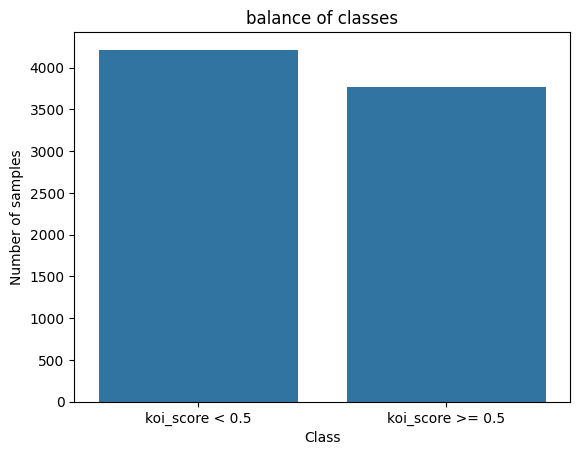

In [55]:
class_counts = y.value_counts().sort_index()
class_labels = ["koi_score < 0.5", "koi_score >= 0.5"]

sns.barplot(x=class_labels, y=class_counts.values)
plt.ylabel("Number of samples")
plt.xlabel("Class")
plt.title("balance of classes")
plt.show()

For classes of `koi_score >= 0.5` and `koi_score < 0.5`, we have a roughly even split between classes. Next, we will combine our X and y tensors into a Torch dataset then use `DataLoader()` which has all kinds of utility.

In [56]:
train_df = TensorDataset(X_train_tensor, y_train_tensor)
test_df = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_df, batch_size=64, shuffle=True)
test_loader = DataLoader(test_df, batch_size=256, shuffle=False)

# deals with weighting to offset any class imbalance
pos_weight = (y_train_tensor.numel() - y_train_tensor.sum()) / y_train_tensor.sum()
pos_weight = pos_weight.to(device)


Now we are ready to build the neural network. This class defines the NN and its various layers. The layers are as follows: a linear transformation, a ReLU activation function (introdues non-lineararity), a dropout layer (randomly sets some elements of the input to zero, helping avoid overfitting), another linear transformation, another ReLU, and a final linear transformation.
The neural network is then trained on the input data `X_train`, and a loss function  and optimizer are defined.

- The BCE loss function is specialised for binary classification, which is what we are doing here. 

- The Adam optimizer is a gradient descent function which contains both the momentum and the square of previous gradients (similar to momentum squared), which is relatively efficient to run.

In [57]:
class MLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        return self.net(x)

model = MLP(input_dim=X_train.shape[1]).to(device)
loss_func = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

Our model is ready to be used. We will pass our training data through the model to improve its accuracy. Each loop is called an *epoch*, the total number of which can have a significant impact on the model's accuracy. We will also print loss and accuracy occasionally, to see it we are getting the model as accurate as can be - too many epochs can lead to overfitting. 

In [68]:
# Training loop
epochs = 10
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device) # sends the tensors to the GPU if possible to speed up processing time
        optimizer.zero_grad()
        logits = model(xb)
        loss = loss_func(logits, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * yb.size(0)

    model.eval()
    with torch.no_grad():
        val_logits = model(X_test_tensor.to(device))
        val_loss = loss_func(val_logits, y_test_tensor.to(device)).item()
        preds = (torch.sigmoid(val_logits) >= 0.5).float().cpu().numpy()
        y_true = y_test_tensor.cpu().numpy()
        val_acc = accuracy_score(y_true, preds)

    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1:02d}/{epochs} ; train_loss={train_loss/len(train_df):.4f} ; val_loss={val_loss:.4f} ; val_acc={val_acc:.3f}")

Epoch 10/10 ; train_loss=0.6140 ; val_loss=0.6160 ; val_acc=0.699


Our model has now been trained on our training data and made its predictions on the test data. With PyTorch we can look at several types of information about the model's ability to predict the test data.
- Accuracy tells you what proportion of the test data was correctly predicted.
- Precision tells you how well the model will predict a positive outcome (in this case, a koi_score < 0.5).
- Recall is the model's ability to avoid false negatives.
- F1 score is the *harmonic mean* of the recall and the precision. A harmonic mean gives more weight to smaller values, meaning a worse precision or recall has an oversized impact on the f1 score.

In [70]:
model.eval()
with torch.no_grad():
    test_logits = model(X_test_tensor.to(device))
    test_probs = torch.sigmoid(test_logits).cpu().numpy().ravel()
    test_preds = (test_probs >= 0.5).astype(int)

test_y = y_test_tensor.cpu().numpy().ravel()
acc = accuracy_score(test_y, test_preds)
prec, rec, f1, _ = precision_recall_fscore_support(test_y, test_preds, average="binary", zero_division=0)

print({"accuracy": acc, "precision": prec, "recall": rec, "f1": f1})

{'accuracy': 0.6989987484355444, 'precision': 0.7014705882352941, 'recall': 0.6317880794701987, 'f1': 0.6648083623693379}


Let's look at a confusion matrix to compare with our results in Q1.

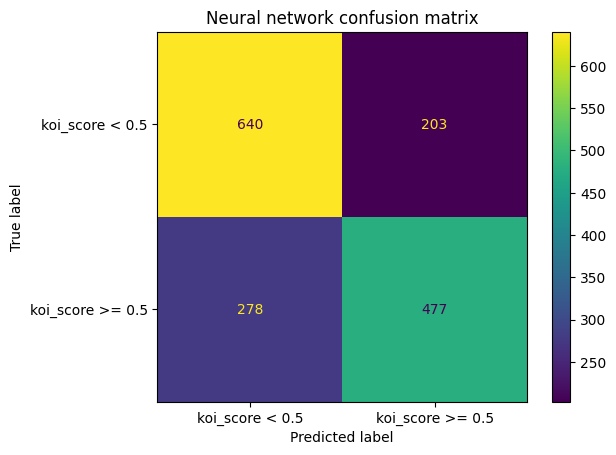

In [71]:
cm = ConfusionMatrixDisplay.from_predictions(test_y, test_preds, display_labels=["koi_score < 0.5", "koi_score >= 0.5"])
plt.title("Neural network confusion matrix")
plt.show()

# Comparison: neural network vs traditional method
We see that the performance of the NN compared to the random forest is mostly similar, however there seem to be fewer correct predictions for `koi_score >= 0.5`, and more incorrect predictions of `koi_score < 0.5`. The overall accuracy of the two is comparable at roughly 70%, and true and false positives are found at an almost identical rate as in the random forest. 

The biggest difference between the two methods in in processing times. On my device, it took a total of 1.5 seconds to run the random forest training and make predictions. The neural network, however, took 7.6 seconds to do the same (with 50 epochs), despite the fact that the resulting accuracy was almost identical. Of course, reducing the number of epochs would reduce run time, but would also reduce accuracy. 

A total of 10 epochs took a time of 1.7 seconds, and resulted in a rather different confusion matrix: more true positives, a similar number of true negatives, fewer false negatives, and more false positives. The ratio of true positives to false positives in Q1 was ~2.667, and in Q2 was ~2.30. A worse ratio would mean more objects are confirmed as exoplanets that are not, which is a big downside of the neural network method; however, the NN method has fewer false negatives (a ratio FN_RF / FN_NN of ~1.25), which corresponds to fewer exoplanets being discounted by the NN than by the random forest. The decision of which is better, then, depends on which outcome is more acceptable.